# Tutorial for PynPoint

In this tutorial we will process a [SPHERE/ZIMPOL](https://www.eso.org/sci/facilities/paranal/instruments/sphere/inst.html) H-alpha dataset of [HD 142527](https://ui.adsabs.harvard.edu/abs/2019A%26A...622A.156C/abstract), for which we make use of preprocessed images. This example highlights some of the functionalities of PynPoint but a complete overview of all pipeline modules is [available in the documentation](https://pynpoint.readthedocs.io/en/latest/overview.html).

## Getting started

We start by importing the require Python modules. 

In [2]:
import tarfile
import configparser
import urllib.request

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

And also the `Pypeline` and the pipeline modules that we need.

In [3]:
from pynpoint import Pypeline, FitsReadingModule, ParangReadingModule, \
                     StarExtractionModule, BadPixelSigmaFilterModule, \
                     StarAlignmentModule, FitCenterModule, ShiftImagesModule, \
                     PSFpreparationModule, PcaPsfSubtractionModule, \
                     FalsePositiveModule, SimplexMinimizationModule, \
                     FakePlanetModule, ContrastCurveModule, \
                     FitsWritingModule, TextWritingModule

Next, we will download the preprocessed images and the parallactic angles.

In [4]:
urllib.request.urlretrieve('https://people.phys.ethz.ch/~stolkert/pynpoint/hd142527_zimpol_h-alpha.tgz',
                           'hd142527_zimpol_h-alpha.tgz')

('hd142527_zimpol_h-alpha.tgz', <http.client.HTTPMessage at 0x137bc3c18>)

And we will unpack the data in a folder called `input`.

In [5]:
tar = tarfile.open('hd142527_zimpol_h-alpha.tgz')
tar.extractall(path='input')

## Creating the configuration file

PynPoint requires a configuration file which contains the global settings and the FITS header keywords that have to be imported. The text file should be called `PynPoint_config.ini` and several examples are [available here](https://pynpoint.readthedocs.io/en/latest/configuration.html). In this case, we don't need any of the header data.

In [6]:
config = configparser.ConfigParser()
config.add_section('header')
config.add_section('settings')
config['settings']['PIXSCALE'] = '0.0036'
config['settings']['MEMORY'] = '100'
config['settings']['CPU'] = '1'

with open('PynPoint_config.ini', 'w') as configfile:
    config.write(configfile)

## Initiating the Pypeline

We can now initiate the `Pypeline` by setting the working, input, and output folders.

In [7]:
pipeline = Pypeline(working_place_in='./',
                    input_place_in='input/',
                    output_place_in='./')

PynPoint v0.8.3

Database: ./PynPoint_database.hdf5
Configuration: ./PynPoint_config.ini

Number of CPUs: 1
Number of threads: not set


The number of CPUs that is used by some of the pipeline modules (see [this page](https://pynpoint.readthedocs.io/en/latest/overview.html)) is set with the `CPU` keyword in the configuration file. Additionally, some of the embedded Python functions (e.g. from `numpy`) use multithreading. This is controlled by setting the `OMP_NUM_THREADS` environmental variable in the terminal (e.g. `export OMP_NUM_THREADS=4`).

## Importing the images and parallactic angles

We will now import the images from the FITS files into the database that is created by PynPoint. This is done by adding an instance of the pipeline module (`FitsReadingModule` in this case) to the `Pypeline` with `add_module`. Then, to directly run the module, we use the `run_module` method of the `Pypeline`. The data is stored in the database by the `image_tag` argument.

In [8]:
module = FitsReadingModule(name_in='read',
                           input_dir=None,
                           image_tag='zimpol',
                           overwrite=True,
                           check=False,
                           filenames=None,
                           ifs_data=False)

pipeline.add_module(module)
pipeline.run_module('read')


-----------------
FitsReadingModule
-----------------

Module name: read
Reading FITS files... [DONE]                      
Output ports: zimpol (70, 1024, 1024), fits_header/cal_OBS091_0235_cam2.fits (868,), fits_header/cal_OBS091_0237_cam2.fits (868,), fits_header/cal_OBS091_0239_cam2.fits (868,), fits_header/cal_OBS091_0241_cam2.fits (868,), fits_header/cal_OBS091_0243_cam2.fits (868,), fits_header/cal_OBS091_0245_cam2.fits (868,), fits_header/cal_OBS091_0247_cam2.fits (868,)


Let's see what the shape is of the dataset with the images. There are 70 images of 1024 by 1024 pixels.

In [8]:
pipeline.get_shape('zimpol')

(70, 1024, 1024)

We will also import the parallactic angles from an ASCII file (a FITS file would also work). These will be stored as the `PARANG` attribute to the dataset that was imported previously.

In [12]:
module = ParangReadingModule(name_in='parang',
                             data_tag='zimpol',
                             file_name='parang.dat',
                             input_dir=None,
                             overwrite=True)

pipeline.add_module(module)
pipeline.run_module('parang')


-------------------
ParangReadingModule
-------------------

Module name: parang
Reading parallactic angles... [DONE]
Number of angles: 70
Rotation range: -14.31 - 34.36 deg
Output port: zimpol (70, 1024, 1024)


The attributes are read from the database with the `get_attribute` method. Let's have a look at the values of the `PARANG` attribute.

In [14]:
pipeline.get_attribute('zimpol', 'PARANG', static=False)

array([-14.3082 , -13.9496 , -13.5902 , -13.23   , -12.8691 , -12.5074 ,
       -12.145  , -11.782  , -11.4182 , -11.0538 ,  -6.43366,  -6.0622 ,
        -5.69037,  -5.3182 ,  -4.9457 ,  -4.57291,  -4.19983,  -3.8265 ,
        -3.45294,  -3.07917,   1.61837,   1.99275,   2.36701,   2.74112,
         3.11507,   3.48882,   3.86237,   4.23567,   4.60872,   4.98149,
         9.6373 ,  10.0041 ,  10.3703 ,  10.736  ,  11.101  ,  11.4653 ,
        11.829  ,  12.192  ,  12.5543 ,  12.9158 ,  17.3717 ,  17.7218 ,
        18.0711 ,  18.4193 ,  18.7666 ,  19.1129 ,  19.4581 ,  19.8024 ,
        20.1456 ,  20.4878 ,  24.9167 ,  25.243  ,  25.568  ,  25.8919 ,
        26.2145 ,  26.536  ,  26.8563 ,  27.1753 ,  27.4931 ,  27.8097 ,
        31.7057 ,  32.0052 ,  32.3035 ,  32.6005 ,  32.8962 ,  33.1906 ,
        33.4838 ,  33.7757 ,  34.0663 ,  34.3556 ])

## Bad pixel correction

In [15]:
module = BadPixelSigmaFilterModule(name_in='badpixel',
                                   image_in_tag='crop',
                                   image_out_tag='bad',
                                   map_out_tag=None,
                                   box=9,
                                   sigma=5.,
                                   iterate=3)

pipeline.add_module(module)
pipeline.run_module('badpixel')


-------------------------
BadPixelSigmaFilterModule
-------------------------

Module name: badpixel
Input port: crop (70, 57, 57)
Deleting data and attributes: bad
Bad pixel sigma filter... [DONE]                      
Output port: bad (70, 57, 57)


The input ports point to datasets in the database that are used as input for the pipeline module. After processing the data, the results are stored by the output port.

## Image centering

In [16]:
module = StarExtractionModule(name_in='extract',
                              image_in_tag='zimpol',
                              image_out_tag='crop',
                              index_out_tag=None,
                              image_size=0.2,
                              fwhm_star=0.03,
                              position=(476, 436, 0.1))

pipeline.add_module(module)
pipeline.run_module('extract')


--------------------
StarExtractionModule
--------------------

Module name: extract
Input port: zimpol (70, 1024, 1024)
Deleting data and attributes: crop
Extracting stellar position... [DONE]                      
Output port: crop (70, 57, 57)


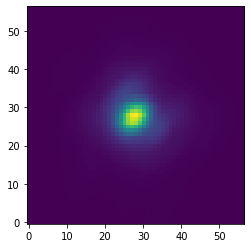

In [17]:
data = pipeline.get_data('crop')
plt.imshow(data[0, ], origin='lower')

In [18]:
module = StarAlignmentModule(name_in='align',
                             image_in_tag='bad',
                             ref_image_in_tag=None,
                             image_out_tag='aligned',
                             interpolation='spline',
                             accuracy=10,
                             resize=None,
                             num_references=10,
                             subframe=0.1)

pipeline.add_module(module)
pipeline.run_module('align')


-------------------
StarAlignmentModule
-------------------

Module name: align
Input port: bad (70, 57, 57)
Deleting data and attributes: aligned
Aligning images... [DONE]                      
Output port: aligned (70, 57, 57)


In [19]:
module = FitCenterModule(name_in='center',
                         image_in_tag='aligned',
                         fit_out_tag='fit',
                         mask_out_tag=None,
                         method='mean',
                         radius=0.1,
                         sign='positive',
                         model='moffat',
                         filter_size=None,
                         guess=(0., 0., 10., 10., 10000., 0., 0., 1.))

pipeline.add_module(module)
pipeline.run_module('center')


---------------
FitCenterModule
---------------

Module name: center
Input port: aligned (70, 57, 57)
Deleting data and attributes: fit
Fitting the stellar PSF... [DONE]
Output port: fit (70, 16)


In [20]:
module = ShiftImagesModule(name_in='shift',
                           image_in_tag='aligned',
                           image_out_tag='centered',
                           shift_xy='fit',
                           interpolation='spline')

pipeline.add_module(module)
pipeline.run_module('shift')


-----------------
ShiftImagesModule
-----------------

Module name: shift
Input ports: aligned (70, 57, 57), fit (70, 16)
Deleting data and attributes: centered
Shifting the images... [DONE]                      
Output port: centered (70, 57, 57)


(17.0, 40.0)

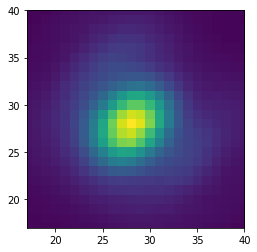

In [17]:
data = pipeline.get_data('centered')
plt.imshow(data[0, ], origin='lower')
plt.xlim(17, 40)
plt.ylim(17, 40)

## Adding a mask

We will now mask the central part of the PSF and also the outer parts of the image. If the `edge_size` is set to a value larger than the field of view, then the image radius is used.

In [21]:
module = PSFpreparationModule(name_in='prep1',
                              image_in_tag='centered',
                              image_out_tag='prep',
                              mask_out_tag=None,
                              norm=False,
                              cent_size=0.02,
                              edge_size=0.2)

pipeline.add_module(module)
pipeline.run_module('prep1')


--------------------
PSFpreparationModule
--------------------

Module name: prep1
Input port: centered (70, 57, 57)
Deleting data and attributes: prep
Preparing images for PSF subtraction... [DONE]                      
Output port: prep (70, 57, 57)


Let's have a look at the first image after masking and make a plot with a logarithmic color scale.

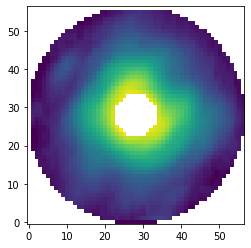

In [22]:
data = pipeline.get_data('prep')
max_flux = np.amax(data[0, ])
plt.imshow(data[0, ], origin='lower', norm=LogNorm(vmin=0.01*max_flux, vmax=max_flux))

We also mask the images that are used as PSF template, which is used for the relative calibration and detection limits, beyond 70 mas.

In [23]:
module = PSFpreparationModule(name_in='prep2',
                              image_in_tag='centered',
                              image_out_tag='psf',
                              mask_out_tag=None,
                              norm=False,
                              cent_size=None,
                              edge_size=0.07)

pipeline.add_module(module)
pipeline.run_module('prep2')


--------------------
PSFpreparationModule
--------------------

Module name: prep2
Input port: centered (70, 57, 57)
Deleting data and attributes: psf
Preparing images for PSF subtraction... [DONE]                      
Output port: psf (70, 57, 57)


Let's also plot one of these images.

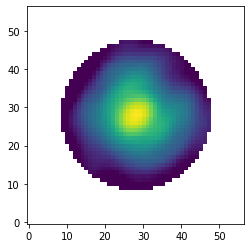

In [21]:
data = pipeline.get_data('psf')
max_flux = np.amax(data[0, ])
plt.imshow(data[0, ], origin='lower', norm=LogNorm(vmin=0.01*max_flux, vmax=max_flux))

## PSF subtraction

We now run the PSF subtraction on the masked images with full-frame PCA with 1 to 30 components and store the mean- and median-collapsed residuals. We also stored the PCA basis and apply an additional rotation of -133 deg to align the positive y axis with North.

In [25]:
module = PcaPsfSubtractionModule(name_in='pca',
                                 images_in_tag='prep',
                                 reference_in_tag='prep',
                                 res_mean_tag='pca_mean',
                                 res_median_tag='pca_median',
                                 basis_out_tag='pca_basis',
                                 pca_numbers=range(1, 31),
                                 extra_rot=-133.,
                                 subtract_mean=True)

pipeline.add_module(module)
pipeline.run_module('pca')


-----------------------
PcaPsfSubtractionModule
-----------------------

Module name: pca
Input port: prep (70, 57, 57)
Deleting data and attributes: pca_mean
Deleting data and attributes: pca_median
Deleting data and attributes: pca_basis
Constructing PSF model... [DONE]


/Users/tomasstolker/applications/pynpoint/pynpoint/core/pypeline.py:312: UserWarning: Pipeline module names need to be unique. Overwriting module 'pca'.
  warnings.warn(f'Pipeline module names need to be unique. Overwriting module '


Creating residuals... [DONE]                      
Output ports: pca_mean (30, 57, 57), pca_median (30, 57, 57), pca_basis (30, 57, 57)


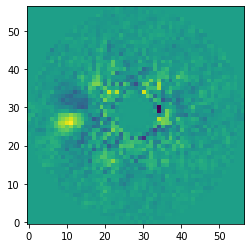

In [26]:
data = pipeline.get_data('pca_median')
plt.imshow(data[14, ], origin='lower')

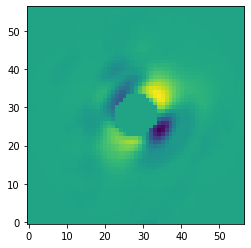

In [27]:
data = pipeline.get_data('pca_basis')
plt.imshow(data[1, ], origin='lower')

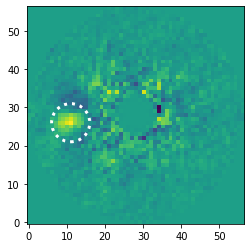

In [28]:
data = pipeline.get_data('pca_median')

fig, ax = plt.subplots()
ax.imshow(data[14, ], origin='lower')
aperture = Circle((11, 26), radius=5, fill=False, ls=':', lw=3., color='white')
ax.add_artist(aperture)

## Signal-to-noise

In [29]:
module = FalsePositiveModule(name_in='snr',
                             image_in_tag='pca_median',
                             snr_out_tag='snr',
                             position=(11., 26.),
                             aperture=5.*0.0036,
                             ignore=True,
                             optimize=False)

pipeline.add_module(module)
pipeline.run_module('snr')


-------------------
FalsePositiveModule
-------------------

Module name: snr
Input port: pca_median (30, 57, 57)
Deleting data and attributes: snr
Calculating S/N and FPF... [DONE]                      
Output port: snr (30, 6)


Text(0, 0.5, 'Signal-to-noise ratio')

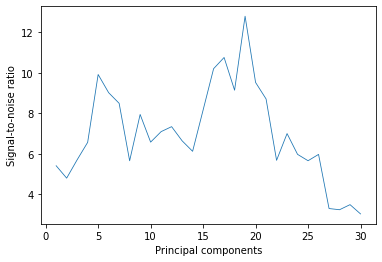

In [30]:
data = pipeline.get_data('snr')
plt.plot(range(1, 31), data[:, 4])
plt.xlabel('Principal components')
plt.ylabel('Signal-to-noise ratio')

## Contrast and position

In [31]:
module = SimplexMinimizationModule(name_in='simplex',
                                   image_in_tag='centered',
                                   psf_in_tag='psf',
                                   res_out_tag='simplex',
                                   flux_position_tag='fluxpos',
                                   position=(11, 26),
                                   magnitude=6.,
                                   psf_scaling=-1.,
                                   merit='gaussian',
                                   aperture=10.*0.0036,
                                   sigma=0.,
                                   tolerance=0.01,
                                   pca_number=range(1, 11),
                                   cent_size=0.02,
                                   edge_size=0.2,
                                   extra_rot=-133.,
                                   residuals='median',
                                   reference_in_tag=None,
                                   offset=None)

pipeline.add_module(module)
pipeline.run_module('simplex')


-------------------------
SimplexMinimizationModule
-------------------------

Module name: simplex
Input ports: centered (70, 57, 57), psf (70, 57, 57)
Deleting data and attributes: simplex001
Deleting data and attributes: fluxpos001
Deleting data and attributes: simplex002
Deleting data and attributes: fluxpos002
Deleting data and attributes: simplex003
Deleting data and attributes: fluxpos003
Deleting data and attributes: simplex004
Deleting data and attributes: fluxpos004
Deleting data and attributes: simplex005
Deleting data and attributes: fluxpos005
Deleting data and attributes: simplex006
Deleting data and attributes: fluxpos006
Deleting data and attributes: simplex007
Deleting data and attributes: fluxpos007
Deleting data and attributes: simplex008
Deleting data and attributes: fluxpos008
Deleting data and attributes: simplex009
Deleting data and attributes: fluxpos009
Deleting data and attributes: simplex010
Deleting data and attributes: fluxpos010
Simplex minimization... 10

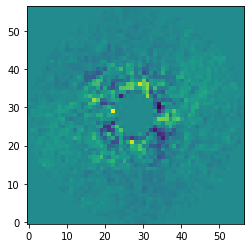

In [29]:
data = pipeline.get_data('simplex010')
plt.imshow(data[-1, ], origin='lower')

Text(0, 0.5, 'Contrast (mag)')

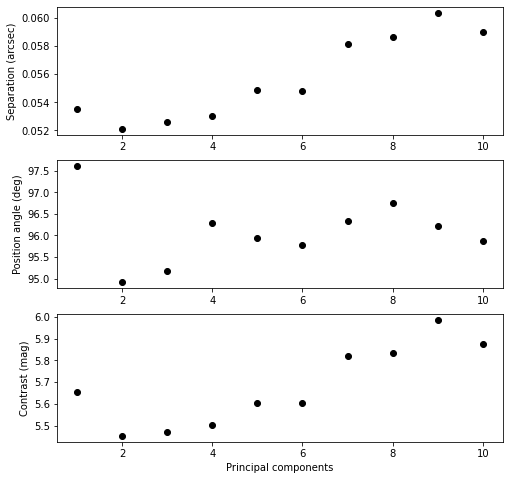

In [30]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

for i in range(1, 11):
    data = pipeline.get_data(f'fluxpos{i:03d}')
    ax1.scatter(i, data[-1, 2], color='black')
    ax2.scatter(i, data[-1, 3], color='black')
    ax3.scatter(i, data[-1, 4], color='black')

ax3.set_xlabel('Principal components')
ax1.set_ylabel('Separation (arcsec)')
ax2.set_ylabel('Position angle (deg)')
ax3.set_ylabel('Contrast (mag)')

## Detection limits

In [31]:
module = FakePlanetModule(position=(0.061, 97.3-133.),
                          magnitude=6.1,
                          psf_scaling=-1.,
                          interpolation='spline',
                          name_in='fake',
                          image_in_tag='centered',
                          psf_in_tag='psf',
                          image_out_tag='removed')

pipeline.add_module(module)
pipeline.run_module('fake')


----------------
FakePlanetModule
----------------

Module name: fake
Input ports: centered (70, 57, 57), psf (70, 57, 57)
Deleting data and attributes: removed
Injecting artificial planets... [DONE]                      
Output port: removed (70, 57, 57)


In [32]:
module = ContrastCurveModule(name_in='limits',
                             image_in_tag='removed',
                             psf_in_tag='psf',
                             contrast_out_tag='limits',
                             separation=(0.05, 5., 0.01),
                             angle=(0., 360., 60.),
                             threshold=('sigma', 5.),
                             psf_scaling=1.,
                             aperture=0.02,
                             pca_number=10,
                             cent_size=0.02,
                             edge_size=2.,
                             extra_rot=-133.,
                             residuals='median')

pipeline.add_module(module)
pipeline.run_module('limits')


-------------------
ContrastCurveModule
-------------------

Module name: limits
Input ports: removed (70, 57, 57), psf (70, 57, 57)
Deleting data and attributes: limits
Calculating detection limits... [DONE]                
Output port: limits (4, 4)


In [33]:
module = FitsWritingModule(name_in='write1',
                           file_name='centered.fits',
                           output_dir=None,
                           data_tag='centered',
                           data_range=None)

pipeline.add_module(module)
pipeline.run_module('write1')


-----------------
FitsWritingModule
-----------------

Module name: write1
Input port: centered (70, 57, 57)
Writing FITS file... [DONE]


In [34]:
module = FitsWritingModule(name_in='write2',
                           file_name='pca_median.fits',
                           output_dir=None,
                           data_tag='pca_median',
                           data_range=None)

pipeline.add_module(module)
pipeline.run_module('write2')


-----------------
FitsWritingModule
-----------------

Module name: write2
Input port: pca_median (30, 57, 57)
Writing FITS file... [DONE]


In [35]:
module = FitsWritingModule(name_in='write3',
                           file_name='simplex.fits',
                           output_dir=None,
                           data_tag='simplex',
                           data_range=None)

pipeline.add_module(module)
pipeline.run_module('write3')


-----------------
FitsWritingModule
-----------------

Module name: write3
Input port: simplex (61, 57, 57)
Writing FITS file... [DONE]


In [36]:
module = TextWritingModule(name_in='write4',
                           file_name='limits.dat',
                           output_dir=None,
                           data_tag='limits',
                           header='Separation [arcsec] - Contrast [mag] - Variance [mag] - FPF')

pipeline.add_module(module)
pipeline.run_module('write4')


-----------------
TextWritingModule
-----------------

Module name: write4
Input port: limits (4, 4)
Writing text file... [DONE]
